Coupling map:


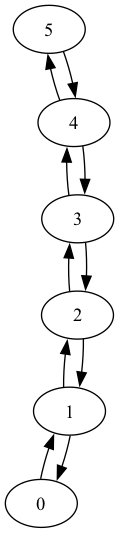

In [1]:
from spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt

num_qubits = 6
rotation_axes = ["rx", "rx", "rx", "rx", "rx", "rx"]
rotation_parameters = [Parameter(f"ϕ_{i}") for i in range(num_qubits)]
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

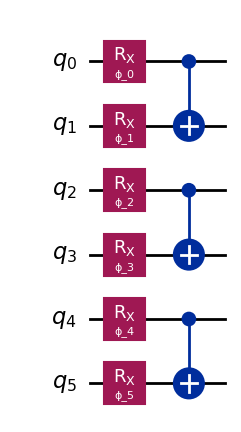

In [2]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

Parameter dictionary:
 {Parameter(ϕ_0): 4.665466064857704, Parameter(ϕ_1): 3.4958331672967256, Parameter(ϕ_2): 1.1607433119572852, Parameter(ϕ_3): 3.9246618340416872, Parameter(ϕ_4): 0.8148633976847353, Parameter(ϕ_5): 6.110646020345377}


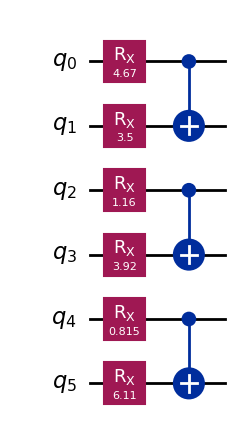

In [3]:
seed = 20983
np.random.seed(seed)
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
# rotation_angles = np.array([0.0, 0.0, np.pi, 0., 0.0, 0.0])
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
print("Parameter dictionary:\n", param_dict)
circuit.assign_parameters(param_dict).draw("mpl")

/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


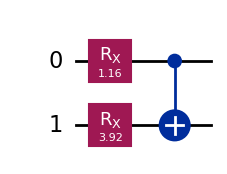

In [4]:
from rl_qoc.helpers import causal_cone_circuit

causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0].draw("mpl")

Text(0.5, 1.0, 'Spillover rate matrix')

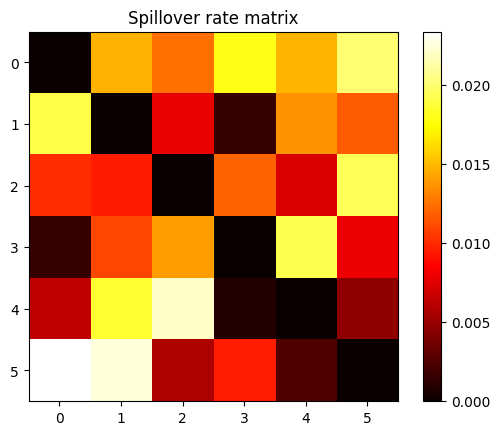

In [35]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.0  # γ_0->1
gamma_matrix[0, 3] = 0.0  # γ_0->3
gamma_matrix[1, 2] = 0.0  # γ_1->2
gamma_matrix[2, 2] = 0.0  # γ_2->2
gamma_matrix[2, 3] = 0.025  # γ_2->3
gamma_matrix[3, 2] = 0.0 # γ_3->2
gamma_matrix[4, 3] = 0.0  # γ_4->3
gamma_matrix[5, 4] = 0.0  # γ_5->4
gamma_matrix = 0.025 * np.round(np.random.rand(num_qubits, num_qubits), 3)
gamma_matrix[np.arange(num_qubits).astype(np.int8),np.arange(num_qubits).astype(np.int8)] = 0
# gamma_matrix[:,[2]] = 0.
# gamma_matrix = 0.05 * np.eye(num_qubits)

# Defining spillover matrix
# gamma_matrix = np.diag(np.ones(num_qubits - 1), k=1) * 0.025
# gamma_matrix += np.diag(np.ones(num_qubits - 1), k=-1) * 0.025
# gamma_matrix += np.diag(np.ones(num_qubits - 2), k=-2) * 0.01
# gamma_matrix += np.diag(np.ones(num_qubits - 2), k=2) * 0.01

# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
#
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

In [36]:
gamma_matrix

array([[0.      , 0.01475 , 0.012475, 0.0179  , 0.01485 , 0.02    ],
       [0.019075, 0.      , 0.0078  , 0.001625, 0.013675, 0.011725],
       [0.010075, 0.0094  , 0.      , 0.011975, 0.007275, 0.019425],
       [0.001625, 0.010975, 0.014025, 0.      , 0.0192  , 0.008   ],
       [0.00635 , 0.0186  , 0.02205 , 0.00085 , 0.      , 0.0047  ],
       [0.02335 , 0.0225  , 0.0058  , 0.00955 , 0.0025  , 0.      ]])

In [37]:
pass_ = LocalSpilloverNoiseAerPass(
    spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
    target_subsystem=(2, 3),
)
pass_.spillover_rate_matrix

array([[0.      , 0.01475 , 0.012475, 0.0179  , 0.01485 , 0.02    ],
       [0.019075, 0.      , 0.0078  , 0.001625, 0.013675, 0.011725],
       [0.010075, 0.0094  , 0.      , 0.011975, 0.007275, 0.019425],
       [0.001625, 0.010975, 0.014025, 0.      , 0.0192  , 0.008   ],
       [0.00635 , 0.0186  , 0.02205 , 0.00085 , 0.      , 0.0047  ],
       [0.02335 , 0.0225  , 0.0058  , 0.00955 , 0.0025  , 0.      ]])

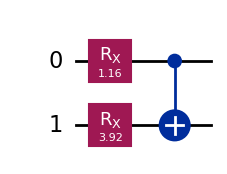

In [38]:
pm = PassManager([pass_])
qc_noisy = causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0]
qc_noisy.draw("mpl")

In [39]:
print(qc_noisy[0].params)
print(qc_noisy[1].params)

[1.1607433119572852]
[3.9246618340416872]


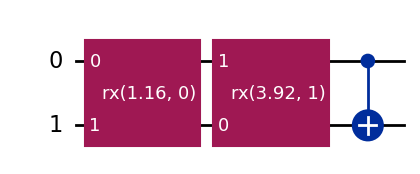

In [40]:
qc_noisy = pm.run(qc_noisy)
qc_noisy.draw("mpl")

In [41]:
print(qc_noisy[0].params)
print(qc_noisy[1].params)

[array([[0.83625892+0.j        , 0.        -0.54833478j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        -0.54833478j, 0.83625892+0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.83625892+0.j        , 0.        -0.54833478j],
       [0.        +0.j        , 0.        +0.j        ,
        0.        -0.54833478j, 0.83625892+0.j        ]])]
[array([[-0.38160732+0.j        ,  0.        -0.92432454j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        -0.92432454j, -0.38160732+0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.38160732+0.j        ,  0.        -0.92432454j],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        -0.92432454j, -0.38160732+0.j        ]])]


In [42]:
qc_noisy.data

[CircuitInstruction(operation=Instruction(name='unitary', num_qubits=2, num_clbits=0, params=[array([[0.83625892+0.j        , 0.        -0.54833478j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        -0.54833478j, 0.83625892+0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.83625892+0.j        , 0.        -0.54833478j],
       [0.        +0.j        , 0.        +0.j        ,
        0.        -0.54833478j, 0.83625892+0.j        ]])]), qubits=(Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)), clbits=()), CircuitInstruction(operation=Instruction(name='unitary', num_qubits=2, num_clbits=0, params=[array([[-0.38160732+0.j        ,  0.        -0.92432454j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        -0.92432454j, -0.38160732+0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,

In [43]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2, 3),
)

In [44]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '22eb18dffcbf4ae4b2aad165138a6f73',
   'operations': ['rx(1.16, 0)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1],
      'params': [array([[0.99530296+0.j        , 0.        -0.09680917j,
               0.        +0.j        , 0.        +0.j        ],
              [0.        -0.09680917j, 0.99530296+0.j        ,
               0.        +0.j        , 0.        +0.j        ],
              [0.        +0.j        , 0.        +0.j        ,
               0.99530296+0.j        , 0.        -0.09680917j],
              [0.        +0.j        , 0.        +0.j        ,
               0.        -0.09680917j, 0.99530296+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(0, 1)]},
  {'type': 'qerror',
   'id': '882085326c7846b79e5be4a17ca1e84b',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1],
      'params': [array([[0.99671556+0.j        , 0.        +0.j        ,
       

In [45]:
from qiskit.transpiler import generate_preset_pass_manager

full_pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
custom_translation_pass = PassManager([pass_] + full_pm.translation._tasks[0])
full_pm.translation = custom_translation_pass

In [46]:
full_pm.translation._tasks

[[<spillover_effect_on_subsystem.LocalSpilloverNoiseAerPass at 0x15a3b7790>,

In [47]:
print("Rotation angles:", rotation_angles)

Rotation angles: [4.66546606 3.49583317 1.16074331 3.92466183 0.8148634  6.11064602]


In [48]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '22eb18dffcbf4ae4b2aad165138a6f73',
   'operations': ['rx(1.16, 0)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1],
      'params': [array([[0.99530296+0.j        , 0.        -0.09680917j,
               0.        +0.j        , 0.        +0.j        ],
              [0.        -0.09680917j, 0.99530296+0.j        ,
               0.        +0.j        , 0.        +0.j        ],
              [0.        +0.j        , 0.        +0.j        ,
               0.99530296+0.j        , 0.        -0.09680917j],
              [0.        +0.j        , 0.        +0.j        ,
               0.        -0.09680917j, 0.99530296+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(0, 1)]},
  {'type': 'qerror',
   'id': '882085326c7846b79e5be4a17ca1e84b',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1],
      'params': [array([[0.99671556+0.j        , 0.        +0.j        ,
       

In [49]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[-0.31912253+0.j        ,  0.        +0.20924857j,
            0.        -0.77297464j, -0.50683929+0.j        ],
          [-0.50683929+0.j        ,  0.        -0.77297464j,
            0.        +0.20924857j, -0.31912253+0.j        ],
          [ 0.        -0.77297464j, -0.50683929+0.j        ,
           -0.31912253+0.j        ,  0.        +0.20924857j],
          [ 0.        +0.20924857j, -0.31912253+0.j        ,
           -0.50683929+0.j        ,  0.        -0.77297464j]],
         input_dims=(2, 2), output_dims=(2, 2))


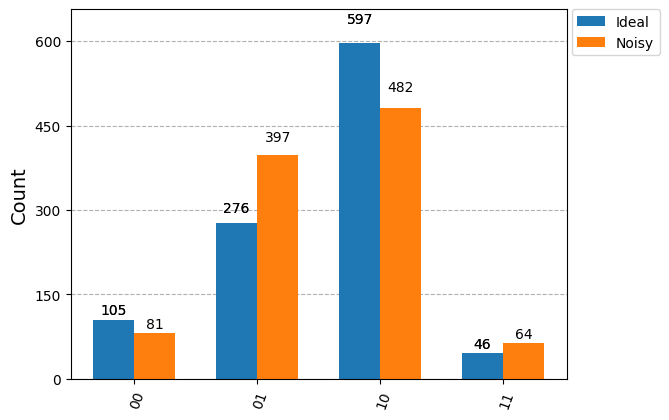

In [50]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [51]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity, average_gate_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
# qc_noisy_ideal_state.save_statevector()
qc_noisy_ideal_state.save_unitary()
# qc_noisy_state.save_statevector()
qc_noisy_state.save_unitary()

# ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
# noisy_state = backend.run(qc_noisy_state).result().get_statevector()
ideal_unitary = ideal_backend.run(qc_noisy_ideal_state).result().get_unitary()
noisy_unitary = backend.run(qc_noisy_state).result().get_unitary()

In [52]:
output_fidelity = average_gate_fidelity(ideal_unitary, noisy_unitary)
output_fidelity

0.9749104723701564

In [53]:
from qiskit import QuantumRegister
from rl_qoc.helpers.circuit_utils import get_gate


# Add here custom ansatz CX gate


def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]

    my_qc.u(
        new_params[0],
        new_params[1] - np.pi/2,
        np.pi/2,
        q_reg[0],
    )

    my_qc.u(
        0.,
        0.,
        new_params[2],
        q_reg[0],
    )

    # my_qc.u(
    #     *new_params[:3],
    #     q_reg[0],
    # ) # # Doesn't handle RX-rotation fine
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    ) # Handles RX-rotation fine

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [54]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig
# from arbitrary_angle_spillover_env import (
#     ArbitraryAngleSpilloverEnv,
# )
# from gate_level.spillover_noise_use_case.generic_spillover.local_spillover_env import (
#     LocalSpilloverEnvironment,
# )

env_metadata = {
    "γ": gamma_matrix,
    "target_subsystem": (2, 3),
    "rotation_axes": rotation_axes,
    "num_qubits": num_qubits,
    "rotation_parameters": rotation_parameters,
    "seed": seed,
}

action_space = Box(low=-1., high=1., shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [2, 3]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
    pass_manager=full_pm,
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[1,],
        n_shots=10,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="channel",
    env_metadata=env_metadata,
)
# q_env = LocalSpilloverEnvironment(
#     q_env_config,
#     circuit_context=circuit.assign_parameters(param_dict),  # Pass the circuit already transpiled through custom pass
# )
# q_env = ArbitraryAngleSpilloverEnv(
#     q_env_config, unbound_circuit_context=circuit, gamma_matrix=gamma_matrix
# )

In [55]:
from typing import Optional, Dict, Any, SupportsFloat
from rl_qoc.environment.context_aware_quantum_environment import ObsType, ActType

class MultiParamAngleSpilloverEnv(ContextAwareQuantumEnvironment):
    """
    Quantum environment with spillover noise on a subsystem where each epoch will have a random set of angles.
    The input circuit context of this environment is expected to have symbolic Parameters for all rotation axes.
    It also should have the form of one layer of single qubit rotation gates (rx, ry, rz) and a layer of two-qubit gates.
    Binding of those parameters will be done automatically at the reset of the environment.
    """

    def __init__(
        self,
        q_env_config: QEnvConfig,
        unbound_circuit_context: QuantumCircuit,
        gamma_matrix: np.ndarray,
        num_params,
        discrete_history_length,
        qubits_with_obs,
        circuit_param_distribution: Optional[str] = "uniform",
        optimal_error_precision: Optional[float] = 1e-4,
    ):
        """
        Initialize the environment
        """
        self.qubits_with_obs = qubits_with_obs
        self.num_obs = len(qubits_with_obs)
        self.num_params = num_params
        self.circuit_param_distribution = circuit_param_distribution
        self.optimal_error_precision = optimal_error_precision
        self.discrete_history_length = discrete_history_length
        self.gamma_matrix = gamma_matrix
        self.circuit_parameters = unbound_circuit_context.parameters

        super().__init__(q_env_config, unbound_circuit_context)
        self._rotation_angles_rng = np.random.default_rng(
            self.np_random.integers(2**32)
        )
        self.observation_space = Box(
            low=np.array([-np.pi] * self.num_obs),
            high=np.array([np.pi] * self.num_obs),
            dtype=np.float64,
        )

        self.discrete_reward_history = np.ones((discrete_history_length, self.num_params))
        self.discrete_obs_vals = np.linspace(
            np.mean(self.observation_space.low), np.mean(self.observation_space.high), self.num_params
        ).flatten()
        self.prob_weights = np.zeros_like(self.discrete_obs_vals)
        print(f"Observation Vals: {self.discrete_obs_vals}")
        self.obs_angles = np.zeros(self.observation_space.shape)

    def define_target_and_circuits(self):
        """
        Define the target gate and the circuits to be executed
        """
        circuit_context = causal_cone_circuit(
            self.circuit_context, list(self.config.env_metadata["target_subsystem"])
        )[0]
        self._physical_target_qubits = list(range(circuit_context.num_qubits))
        self._circuit_context = circuit_context
        target, custom_circuits, baseline_circuits = (
            super().define_target_and_circuits()
        )

        return target, custom_circuits, baseline_circuits

    def reset(
        self,
        debug_obs: Optional[np.ndarray] = None,
        *,
        seed: Optional[int] = None,
        options: Optional[Dict[str, Any]] = None,
    ) -> tuple[ObsType, dict[str, Any]]:
        """
        Reset the environment
        :param seed: Seed for the environment
        :param options: Options for the environment
        :return: Initial observation and info
        """

        # Reset the environment
        old_angles, info = super().reset(seed=seed, options=options)

        if debug_obs is not None:
            self.obs_angles = debug_obs
        else:
            self.obs_angles = self._get_new_angles()

        phi = np.zeros(self.unbound_circuit_context.num_qubits)
        phi[self.qubits_with_obs] = self.obs_angles

        param_dict = {self.circuit_parameters[i].name: phi[i] for i in range(len(phi))}
        circuit = self.unbound_circuit_context.assign_parameters(param_dict)
        backend = noisy_backend(
            circuit, self.gamma_matrix, self.config.env_metadata["target_subsystem"]
        )
        # Generate the initial observation
        self.set_circuit_context(None, backend=backend, **param_dict)
        env_obs = self._get_obs()
        print("Sampled angles: ", phi)
        print(f"Environment Observation: {env_obs}")
        # Return the initial observation and info
        return env_obs, {}
    
    def _get_new_angles(self):
        if self.circuit_param_distribution == "uniform":
            angles = np.random.uniform(
                self.observation_space.low, self.observation_space.high, self.observation_space.shape
            )
        if self.circuit_param_distribution == "simple_discrete":
            self.prob_weights = np.ones_like(self.discrete_obs_vals)
            self.prob_weights /= np.sum(self.prob_weights)
            angles = np.random.choice(
                a=self.discrete_obs_vals, 
                size=len(self.observation_space.shape), 
                p=self.prob_weights,
                replace=True
            )
        if self.circuit_param_distribution == "moving_discrete":
            self.prob_weights = (np.mean(
                self.discrete_reward_history, axis=0
            ) + np.log10(self.optimal_error_precision)) ** 2
            self.prob_weights /= np.sum(self.prob_weights)
            angles = np.random.choice(
                a=self.discrete_obs_vals, 
                size=len(self.observation_space.shape), 
                replace=True,
                p=self.prob_weights
            )
        return angles
    
    def step(
        self, action: ActType
    ) -> tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]:

        print(f"batch action shape: {action.shape}")
        
        obs, reward, terminated, truncated, info = super().step(action)
        print(f"obs: {obs}")
        print(f"reward: {reward}")

        if self.circuit_param_distribution != "uniform":
            self.update_discrete_history(reward, obs)

        return obs, reward, terminated, truncated, info
    
    def update_discrete_history(self, reward, obs):
        obs_ind = np.argmin(np.abs(self.discrete_obs_vals - obs * np.pi))
        self.discrete_reward_history[:, obs_ind] = np.append(
            [np.mean(reward)], self.discrete_reward_history[:-1, obs_ind], axis=0
        )
    
    # def initialize_discrete_history(self):
    #     # Initializes Discrete History with success of zeros policy
    #     for set_obs in np.tile(self.discrete_obs_vals, (self.discrete_history_length,)):
    #         _obs, info = self.reset(debug_obs=np.array([set_obs]))
    #         obs, reward, terminated, truncated, info = self.step(np.zeros((self.batch_size,) + self.action_space.shape))
    
    def clear_history(self):
        super().clear_history()
        self.discrete_reward_history = np.ones_like(self.discrete_reward_history)

    def _get_obs(self):
        """
        Get the observation
        :return: Observation
        """
        return self.obs_angles / np.pi # Normalized to multiples of pi

    def _get_info(self) -> Any:
        return {}

In [56]:
one_q_env = MultiParamAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix, 
    num_params=17,
    discrete_history_length=3,
    qubits_with_obs=np.array([0, 1, 2, 3, 4, 5], dtype=np.int8),
    circuit_param_distribution="uniform",
    optimal_error_precision=1e-5
)

Observation Vals: [-3.14159265 -2.74889357 -2.35619449 -1.96349541 -1.57079633 -1.17809725
 -0.78539816 -0.39269908  0.          0.39269908  0.78539816  1.17809725
  1.57079633  1.96349541  2.35619449  2.74889357  3.14159265]


In [57]:
# Testing n-reps fitting

from typing import Callable, Any, Optional, List, Literal
from scipy.optimize import curve_fit

def _fit_function(n, eps_quad):
    return 3/5 + 2/5 * np.cos(n * eps_quad)

def _fit_function_2(n, delta_1, delta_2):
    return (4 * np.cos(n * delta_1)**2 * np.cos(n * delta_2)**2 + 1) / 5

def _inverse_fit_function(reward, n, spam, eps_lin, eps_quad):
    return reward + eps_lin * (n - 1) + eps_quad * (n**2 - 1)

def custom_reward_fit(
    env,
    params: np.array,
    execution_config: Optional[ExecutionConfig] = None,
    fit_function: Optional[Callable] = None,
    inverse_fit_function: Optional[Callable] = None,
    update_fit_params: bool = True,
    reward_method: Optional[
        Literal["cafe", "channel", "orbit", "state", "xeb", "fidelity"]
    ] = None,
) -> plt.Figure:
    """
    Method to fit the initial reward function to the first set of actions in the environment
    with respect to the number of repetitions of the cycle circuit
    """

    initial_execution_config = env.config.execution_config
    initial_reward_method = env.config.reward_method
    if execution_config is not None:
        env.config.execution_config = execution_config
    if reward_method is not None:
        env.config.reward_method = reward_method
    reward_data = []
    for i in range(len(env.config.execution_config.n_reps)):
        env.config.execution_config.n_reps_index = i
        reward = env.perform_action(params, update_env_history=False)
        reward_data.append(np.mean(reward))
    if fit_function is None or inverse_fit_function is None:
        fit_function = _fit_function
        inverse_fit_function = _inverse_fit_function

    p0 = [0.078,]  # Initial guess for the parameters
    lower_bounds = [0.0,]
    upper_bounds = [10.,]

    popt, pcov = curve_fit(
        fit_function,
        env.config.execution_config.n_reps,
        reward_data,
        p0=p0,
        bounds=(lower_bounds, upper_bounds),
    )

    # Create a figure and return it to the user
    fig, ax = plt.subplots()
    ax.plot(
        env.config.execution_config.n_reps, reward_data, label="Data", marker="o"
    )
    ax.plot(
        env.config.execution_config.n_reps,
        [fit_function(n, *popt) for n in env.config.execution_config.n_reps],
        label="Fit",
    )
    ax.set_xlabel("Number of repetitions")
    ax.set_ylabel("Reward")
    ax.legend()
    ax.set_title("Initial reward fit (for varying number of repetitions)")
    # Print found parameters
    print("Found parameters:", popt)

    if execution_config is not None:
        env.config.execution_config = initial_execution_config
    if reward_method is not None:
        env.config.reward_method = initial_reward_method
    if update_fit_params:
        env._fit_function = lambda reward, n: inverse_fit_function(
            reward, n, *popt
        )
        env._fit_params = popt
    return fig, reward_data

Sampled angles:  [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265]
Environment Observation: [1. 1. 1. 1. 1. 1.]
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.978819151842502
Reward (avg): 0.9780701829093452 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.978819151842502
Reward (avg): 0.960176592411252 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.978819151842502
Reward (avg): 0.9026638738778772 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.978819151842502
Reward (avg): 0.8435765807397771 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.978819151842502
Reward (avg): 0.7476283762201168 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.978819151842502
Reward (avg): 0.6837431280513708 Std: 0.0
Starting simulation bench

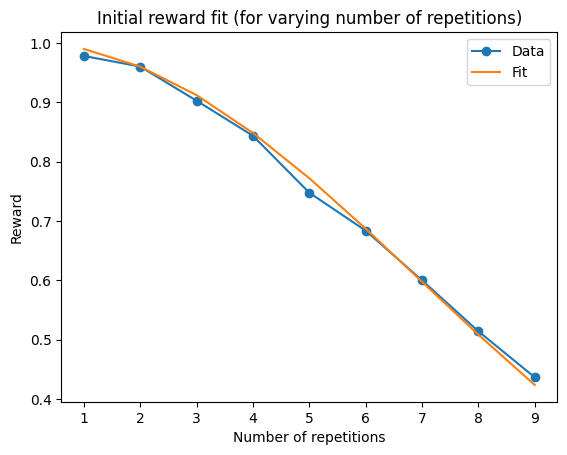

In [58]:
_obs, info = one_q_env.reset(debug_obs=np.array([np.pi] * 6))

fig, reward_data = custom_reward_fit(  
    one_q_env,
    np.zeros((1, 7)),
    ExecutionConfig(
        sampling_paulis=1000,
        n_shots=100,
        n_reps=list(
            range(1, 10),
        ),
        dfe_precision=None,
        seed=q_env_config.seed,
        control_flow_enabled=False,
    ),
    update_fit_params=False,
    reward_method=None,
)

In [59]:
# PPO Details

from ppo_cleanrl import PPO_CleanRL

one_q_env = MultiParamAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix, 
    num_params=17,
    discrete_history_length=3,
    qubits_with_obs=np.array([0, 1, 2, 3, 4, 5], dtype=np.int8),
    circuit_param_distribution="uniform",
    optimal_error_precision=1e-5
)

agent_config = {
    "exp_name": "Test PPO CleanRL",
    "seed": 1,
    "torch_deterministic": True,
    "cuda": False,
    "track": False,
    "wandb_project_name": "Context Aware Calibrations",
    "wandb_entity": None,
    "save_model": True,
    "plot_real_time": True,
    "num_prints": 5,
    "total_updates": 800,
    "learning_rate": 3e-3,
    "num_envs": 32,
    "num_steps": 1,
    "anneal_lr": True,
    "anneal_num_updates": 1600,
    "exp_anneal_lr": False,
    "exp_update_time": 100,
    "plateau_lr": 1e-6,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "num_minibatches": 4,
    "update_epochs": 8,
    "norm_adv": True,
    "activation_function_str": "elu",
    "use_combined_networks": False,
    "layer_size": 64,
    "clip_coef": 0.2,
    "clip_vloss": True,
    "ent_coef": 0.0,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "target_kl": None,
    "robust_ppo": False,
}

# alt_q_env.clear_history()
rescaled_q_env = RescaleAndClipAction(one_q_env, min_action=-1., max_action=1.)
ppo_agent = PPO_CleanRL(agent_config, rescaled_q_env)

Observation Vals: [-3.14159265 -2.74889357 -2.35619449 -1.96349541 -1.57079633 -1.17809725
 -0.78539816 -0.39269908  0.          0.39269908  0.78539816  1.17809725
  1.57079633  1.96349541  2.35619449  2.74889357  3.14159265]


In [60]:
print(ppo_agent.env.observation_space)

Box(-3.141592653589793, 3.141592653589793, (6,), float64)


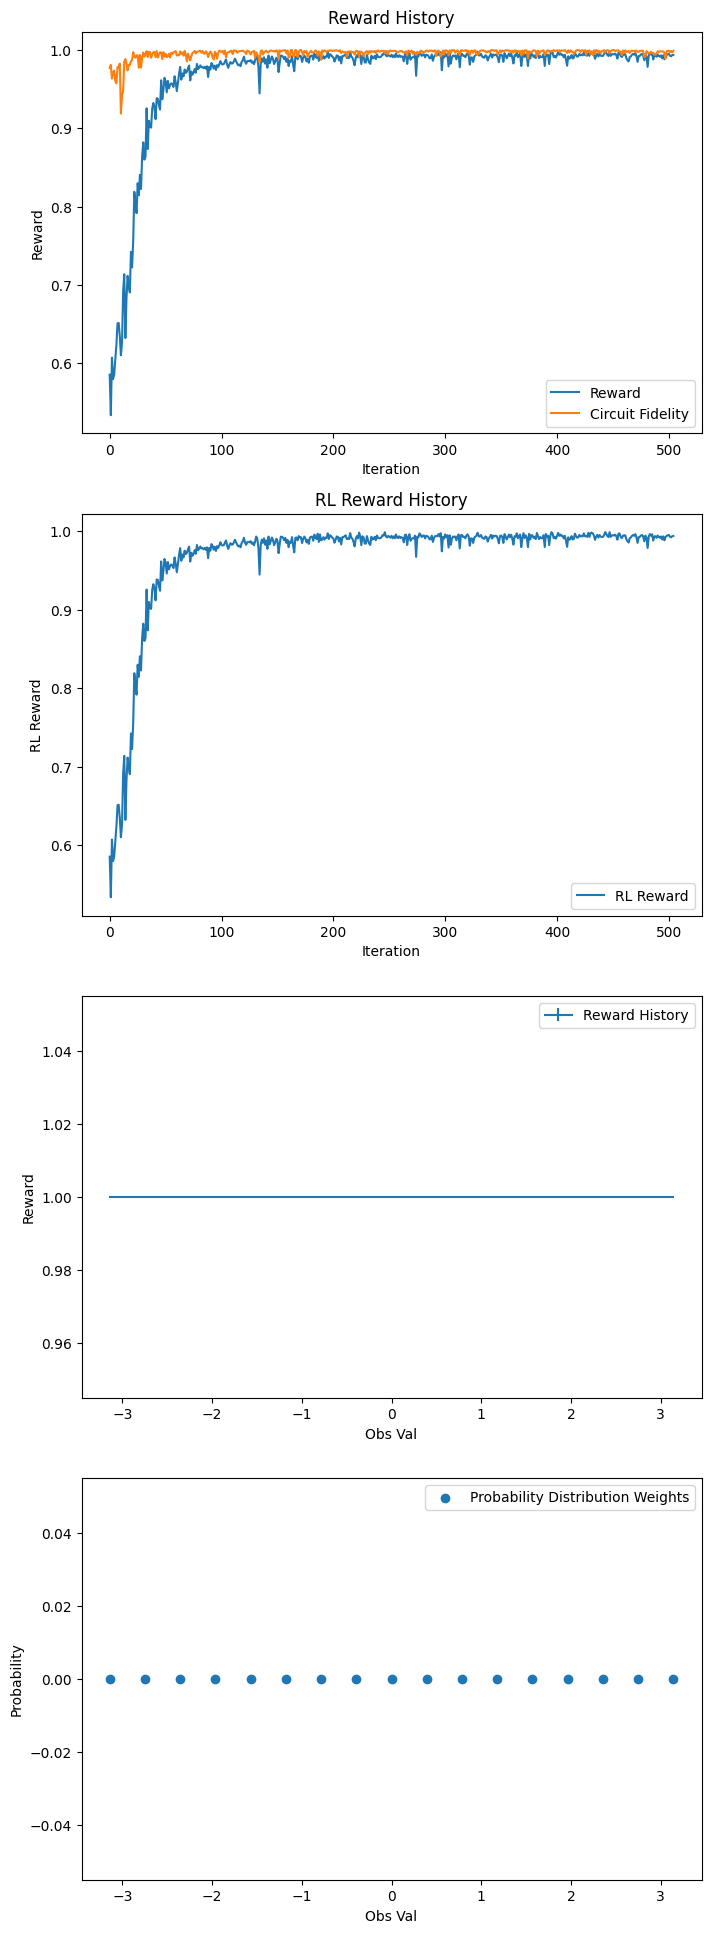

/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9991186647836141


KeyboardInterrupt: 

In [61]:
# from gymnasium.wrappers import ActionWrapper

ppo_agent.env.unwrapped.clear_history()
# ppo_agent.env.clear_history()
ppo_agent.run_training()

In [62]:
# Testing the policy of the agent for some random observations

import torch
from torch import Tensor

num_random_obs = 25
obs_arr = np.zeros((num_random_obs, 6))
mean_action_arr = np.zeros((num_random_obs, 7))
mean_reward_arr = np.zeros(num_random_obs)

for i in range(num_random_obs):
    _obs, info = ppo_agent.env.reset()
    obs_arr[i] = _obs

    batch_obs = np.tile(_obs, (32, 1))
    batch_obs = Tensor(batch_obs)

    with torch.no_grad():
        action, logprob, _, value = ppo_agent.agent.get_action_and_value(
            batch_obs
        )
    
    cpu_action = action.cpu().numpy()

    mean_action = np.mean(cpu_action, axis=0)
    mean_action_arr[i] = mean_action

    ppo_agent.env.unwrapped.mean_action = ppo_agent.env.action(mean_action)

    next_obs, reward, terminations, truncations, infos = ppo_agent.env.step(
        cpu_action
    )
    mean_reward_arr[i] = np.mean(reward)

Sampled angles:  [ 3.04134093  0.36380121  1.22492054  0.67019207 -0.53148882  2.9078071 ]
Environment Observation: [ 0.96808888  0.11580152  0.38990432  0.21332876 -0.16917815  0.92558375]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9916839979061283


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9795169572017945 Std: 0.01458631757520279
obs: [ 0.96808888  0.11580152  0.38990432  0.21332876 -0.16917815  0.92558375]
reward: [2.00441368 6.         2.004151   1.83702413 1.52174359 1.45755096
 1.96631657 1.75400944 6.         1.33411357 6.         1.58410485
 1.56075214 2.07459441 1.63173078 1.56415153 1.77500283 1.94726517
 1.98513841 1.36417211 1.70704873 1.47379981 1.53863339 2.26300882
 1.68688926 1.26622382 1.78197731 1.52724719 1.60861874 1.46725585
 1.65877345 1.62550582]
Sampled angles:  [-2.89507154  1.52151434  0.54972572 -2.5905304   2.31531271 -0.94747349]
Environment Observation: [-0.92152989  0.48431306  0.17498313 -0.82459144  0.73698692 -0.30159018]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9990324948135862


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9989631218433762 Std: 0.018230462601114068
obs: [-0.92152989  0.48431306  0.17498313 -0.82459144  0.73698692 -0.30159018]
reward: [6.         1.23223508 6.         6.         1.85653514 1.79229853
 6.         2.08538555 1.91556062 6.         1.50875041 3.1765398
 3.15444107 4.4811586  2.53927711 6.         1.38369942 6.
 6.         6.         2.52741841 6.         2.02507884 6.
 6.         1.94566099 2.32374209 2.01301464 2.68234393 6.
 6.         6.        ]
Sampled angles:  [ 0.65238651 -2.66421709 -0.88392432  3.08500626  0.26456981  1.8926318 ]
Environment Observation: [ 0.20766108 -0.84804664 -0.28136185  0.98198799  0.08421519  0.60244341]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9964417863379398


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.0033011303930615 Std: 0.012301507683832648
obs: [ 0.20766108 -0.84804664 -0.28136185  0.98198799  0.08421519  0.60244341]
reward: [2.41312467 3.23532944 6.         6.         6.         2.36116851
 6.         6.         2.18629118 6.         6.         2.71999084
 2.06245075 2.16647492 2.47549378 6.         1.99821823 6.
 6.         6.         1.58700442 6.         6.         1.51599185
 6.         3.56888024 6.         2.87794088 6.         6.
 6.         6.        ]
Sampled angles:  [ 0.2419555   0.37082302  0.62771803 -0.05643181  2.73830407 -1.91863615]
Environment Observation: [ 0.07701683  0.11803663  0.19980885 -0.0179628   0.87162926 -0.61072085]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9971800143445984


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9976587602483926 Std: 0.01384454161356967
obs: [ 0.07701683  0.11803663  0.19980885 -0.0179628   0.87162926 -0.61072085]
reward: [6.         2.2266415  1.58120446 6.         1.92852337 1.5384089
 6.         2.68071151 6.         6.         6.         6.
 6.         1.72612224 6.         6.         1.80658485 2.3861765
 2.15953055 2.14060753 2.3519107  3.53016139 1.58300075 1.93608329
 6.         6.         2.03865901 2.24708738 1.75569937 1.77834691
 6.         2.14108699]
Sampled angles:  [-2.06341298 -1.95425377 -2.16214342  2.15010657  2.18939007 -1.35351187]
Environment Observation: [-0.65680475 -0.6220583  -0.68823162  0.68440018  0.6969045  -0.43083621]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9994061531877779


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9953233108214234 Std: 0.015846137277163518
obs: [-0.65680475 -0.6220583  -0.68823162  0.68440018  0.6969045  -0.43083621]
reward: [6.         6.         2.24158539 2.35948159 6.         2.39341706
 6.         6.         1.53731759 2.20151383 1.96644194 2.32627567
 6.         2.05667929 6.         2.13416038 1.58664869 1.59808751
 6.         2.52498581 2.41842377 1.78288551 6.         1.8349223
 6.         2.30201824 2.05019204 6.         1.75131005 1.94617709
 1.50697361 1.40252332]
Sampled angles:  [0.17510774 2.93391787 1.94322456 1.63942381 1.99419255 0.26330309]
Environment Observation: [0.05573853 0.93389506 0.61854759 0.52184481 0.6347712  0.08381198]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9929379509736302


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9883660793684041 Std: 0.011758049256699807
obs: [0.05573853 0.93389506 0.61854759 0.52184481 0.6347712  0.08381198]
reward: [1.64634765 2.98708935 1.84605345 2.27686722 1.42989666 2.56451312
 2.41924046 1.60650456 2.47278428 2.00736428 1.82296327 2.01117643
 6.         6.         1.68622668 2.49895075 1.5557174  1.53354264
 2.02323371 2.06575769 2.40387356 3.4393378  6.         1.48285275
 1.96002588 1.7092245  1.81292267 1.55406569 1.87792375 2.13195876
 2.81060433 1.79285733]
Sampled angles:  [-3.00833346  2.75292905 -2.99688363 -2.35368448  2.14824627  1.82790171]
Environment Observation: [-0.95758228  0.87628453 -0.95393769 -0.74920104  0.68380802  0.58183919]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9988991977303368


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9945631693736012 Std: 0.011683275235483825
obs: [-0.95758228  0.87628453 -0.95393769 -0.74920104  0.68380802  0.58183919]
reward: [6.         2.65446688 1.73282618 1.80787091 6.         2.29870211
 2.81016225 1.94168152 1.42041615 6.         3.19444795 6.
 1.65796805 2.64787612 6.         2.47663939 2.42642389 1.72194387
 6.         1.93316686 2.01734397 3.12368908 6.         6.
 1.90394072 1.75852614 6.         1.86075589 1.96300716 2.93344659
 1.59759363 6.        ]
Sampled angles:  [ 2.86191158 -0.23050953 -0.13233707 -0.36428192 -0.93556701  2.74064387]
Environment Observation: [ 0.91097475 -0.07337346 -0.0421242  -0.11595454 -0.29780023  0.87237404]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelity:  0.9954615143137022
Reward (avg): 0.9942987822333109 Std: 0.013452113592018674
obs: [ 0.91097475 -0.07337346 -0.0421242  -0.11595454 -0.29780023  0.87237404]
reward: [2.677593   1.76641931 1.5347596  2.52902265 6.         2.06215893
 6.         3.15539997 2.41602788 2.17694598 2.71103816 6.
 1.9071774  1.56816919 2.05599535 2.37550746 6.         6.
 1.57172328 2.62141538 6.         6.         6.         1.96464902
 2.14729203 2.54667107 1.76632231 6.         1.44447264 2.96958215
 1.61130338 1.78026548]
Sampled angles:  [ 1.85469054 -1.97780833 -0.98287384 -0.83050564  1.8575186  -0.25233492]
Environment Observation: [ 0.59036634 -0.62955594 -0.31285846 -0.26435816  0.59126653 -0.0803207 ]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9972042551444901


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9897275181432248 Std: 0.014805985043829507
obs: [ 0.59036634 -0.62955594 -0.31285846 -0.26435816  0.59126653 -0.0803207 ]
reward: [6.         2.57646759 6.         1.54520661 1.38789832 6.
 2.87245573 2.21628617 1.58368551 1.63760547 6.         2.35250338
 1.74831227 1.56441136 1.76343959 1.43297725 2.16473305 6.
 6.         6.         1.89005201 1.90179983 1.72044019 1.71012301
 1.68299826 1.52015268 2.27288487 1.87808661 6.         6.
 1.7608925  2.54513091]
Sampled angles:  [-2.71478069 -1.5450284  -2.16420452 -2.60248197  0.57458944  2.9142267 ]
Environment Observation: [-0.86414153 -0.49179781 -0.6888877  -0.82839574  0.1828975   0.92762717]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9984973962197354


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9952714921389512 Std: 0.0168764353667831
obs: [-0.86414153 -0.49179781 -0.6888877  -0.82839574  0.1828975   0.92762717]
reward: [6.         3.88320435 1.69902575 6.         6.         2.09105076
 6.         2.25465679 6.         6.         1.66323182 1.98492476
 1.60216875 1.53639742 6.         3.10264163 1.90860931 6.
 1.77769371 6.         2.35809223 3.26471445 6.         1.65966308
 3.00859916 6.         1.54766348 1.90659178 2.17063895 1.53054254
 1.83695556 1.46171479]
Sampled angles:  [ 0.26735274  0.05566892  2.39318225 -0.88514495 -1.03010156  1.795165  ]
Environment Observation: [ 0.08510102  0.01771997  0.76177357 -0.28175039 -0.32789151  0.57141877]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9978685806987752


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9948060688841818 Std: 0.016889007582973677
obs: [ 0.08510102  0.01771997  0.76177357 -0.28175039 -0.32789151  0.57141877]
reward: [2.26285658 2.03827052 1.87657183 1.71952724 1.84719954 3.29286129
 1.74263113 1.43655963 6.         2.43364594 1.95026065 3.20654558
 2.16761762 1.87690835 2.20201981 2.05281165 6.         1.69303989
 6.         1.74454818 6.         2.14817299 2.23902739 1.43142842
 6.         6.         6.         1.75703953 1.87454249 6.
 6.         2.45991322]
Sampled angles:  [-1.44117964  0.03697675  0.24504081  1.73232231 -2.75658043  0.58093435]
Environment Observation: [-0.45874173  0.01177007  0.07799891  0.55141532 -0.8774468   0.18491715]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9991067976542098


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9988175950494891 Std: 0.012183336787340435
obs: [-0.45874173  0.01177007  0.07799891  0.55141532 -0.8774468   0.18491715]
reward: [2.39578702 6.         1.63438436 1.54921225 2.19012079 6.
 6.         2.07627294 2.14892835 6.         2.09987777 2.15499455
 2.10238499 3.05916306 2.76153205 2.54403711 6.         2.72517644
 6.         2.86931276 1.9597316  6.         2.77570003 1.78022728
 6.         6.         2.13856467 1.73858244 2.10522734 6.
 6.         6.        ]
Sampled angles:  [ 1.61940907  0.98672188  2.6970388   0.88219978 -1.29187631  1.8852611 ]
Environment Observation: [ 0.51547392  0.31408333  0.85849411  0.28081291 -0.411217    0.60009725]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.994354303122703


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9904902300711134 Std: 0.01837510265691243
obs: [ 0.51547392  0.31408333  0.85849411  0.28081291 -0.411217    0.60009725]
reward: [1.79434146 6.         2.62042141 6.         1.38514157 1.9360639
 1.42124311 2.83828679 2.118877   6.         6.         1.273096
 1.36337021 1.48367842 1.55633177 1.83982477 6.         3.04962691
 6.         6.         1.8242432  1.70723754 6.         1.97456721
 2.1870693  6.         2.33232748 1.85417566 6.         1.72488093
 6.         1.57683144]
Sampled angles:  [-2.88122149  1.0574254   2.86639705 -1.1931674  -0.61176577 -1.33756137]
Environment Observation: [-0.91712128  0.33658896  0.91240252 -0.37979698 -0.19473109 -0.42575901]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelity:  0.9983859042122771
Reward (avg): 0.9923100081873141 Std: 0.015815195788706993
obs: [-0.91712128  0.33658896  0.91240252 -0.37979698 -0.19473109 -0.42575901]
reward: [1.93081217 1.94462331 1.45242077 6.         2.55031159 1.76855775
 2.108869   6.         6.         1.97512971 1.57429485 1.71905416
 6.         1.85782435 2.10590178 1.52113237 2.06628766 6.
 1.36198451 1.75557268 6.         1.72565906 6.         2.18159848
 6.         6.         2.23954744 2.10457399 1.75725059 3.14831509
 2.01889887 1.78893273]
Sampled angles:  [-1.04677982  0.73982507  0.69685372  0.00474241 -2.75644586  2.10739454]
Environment Observation: [-0.33320037  0.23549364  0.22181543  0.00150956 -0.87740397  0.67080451]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9991429823745615


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.997312975003265 Std: 0.015120955139235673
obs: [-0.33320037  0.23549364  0.22181543  0.00150956 -0.87740397  0.67080451]
reward: [6.         6.         1.8516099  2.55608927 6.         2.47885101
 2.59342167 1.90432675 1.74795942 6.         2.84989617 6.
 6.         6.         1.76180754 2.80464981 6.         6.
 1.5438526  6.         1.50151774 6.         2.25263579 3.03110111
 1.80997451 1.34458188 6.         2.23200758 6.         1.73107736
 2.1994406  6.        ]
Sampled angles:  [-0.25014292 -0.32456019  0.23284715 -2.09081171 -2.50032194 -1.21432406]
Environment Observation: [-0.07962296 -0.10331072  0.07411755 -0.66552604 -0.79587719 -0.38653135]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9980596359755476


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9975953008622805 Std: 0.013105435690231112
obs: [-0.07962296 -0.10331072  0.07411755 -0.66552604 -0.79587719 -0.38653135]
reward: [6.         6.         6.         2.27308708 1.91712    2.01548145
 1.97606136 2.06138343 1.95647982 6.         1.66064423 2.72366238
 1.7739026  2.19990745 6.         6.         6.         1.594254
 6.         1.69686657 1.63313678 6.         6.         6.
 6.         1.95988155 1.9410754  6.         2.26935166 2.00212369
 6.         2.09132842]
Sampled angles:  [ 1.20647046 -1.42208326  0.78119131  2.18784638  1.45352452  0.65775399]
Environment Observation: [ 0.38403147 -0.45266316  0.24866092  0.69641313  0.46267122  0.2093696 ]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9954365633168291


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.003487520062494 Std: 0.014964458774799459
obs: [ 0.38403147 -0.45266316  0.24866092  0.69641313  0.46267122  0.2093696 ]
reward: [6.         6.         1.91185684 1.79294323 2.76567807 1.54262484
 2.59692714 6.         1.99944671 6.         2.10440099 6.
 1.64568772 6.         6.         6.         6.         2.02805739
 6.         6.         6.         6.         2.57022222 1.86473789
 2.07227552 6.         2.52559082 6.         6.         6.
 6.         6.        ]
Sampled angles:  [ 2.25551043 -2.77915824  1.66436015 -1.75304655 -2.71937475  2.9898564 ]
Environment Observation: [ 0.71795127 -0.88463354  0.52978229 -0.55801205 -0.86560387  0.95170085]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9984838384864171


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.0008884250529495 Std: 0.012907771452546981
obs: [ 0.71795127 -0.88463354  0.52978229 -0.55801205 -0.86560387  0.95170085]
reward: [1.94374147 6.         1.85439512 2.05805519 6.         6.
 1.64597034 6.         2.50255849 2.11394384 1.55483179 6.
 6.         2.42042616 6.         6.         6.         6.
 3.67056965 6.         6.         3.10899901 6.         6.
 2.59354203 1.78658446 6.         1.98708292 2.38989877 1.7821451
 2.45855325 6.        ]
Sampled angles:  [-0.9129655  -2.88489998  0.73952407  1.53596539 -2.8689112  -0.82231277]
Environment Observation: [-0.29060594 -0.91829218  0.23539782  0.48891297 -0.9132028  -0.26175028]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9979958331257593


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.0021967524035071 Std: 0.01581894411057051
obs: [-0.29060594 -0.91829218  0.23539782  0.48891297 -0.9132028  -0.26175028]
reward: [6.         1.55992417 6.         6.         6.         6.
 6.         6.         1.71810162 6.         6.         2.8668636
 3.18579106 1.58988309 6.         1.82638539 6.         6.
 1.68849707 1.71097702 6.         2.24133008 6.         6.
 6.         6.         6.         6.         2.00456264 6.
 6.         1.72150914]
Sampled angles:  [ 2.45461835 -3.07018912 -1.00101615 -2.41638394  2.19386198 -2.82191715]
Environment Observation: [ 0.78132929 -0.97727155 -0.31863334 -0.7691589   0.69832796 -0.89824413]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9988530625329212


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.0006050801797082 Std: 0.015283432146855692
obs: [ 0.78132929 -0.97727155 -0.31863334 -0.7691589   0.69832796 -0.89824413]
reward: [6.         1.62823518 6.         1.7357703  6.         1.48831629
 2.42093889 6.         6.         1.60601771 1.8404012  6.
 6.         6.         6.         2.36071282 6.         2.2556136
 6.         3.23269703 6.         2.1388095  6.         6.
 6.         6.         1.98204381 1.93381367 6.         2.1695801
 1.65651749 2.18491128]
Sampled angles:  [ 1.21278384 -1.62623225 -1.08315094 -2.29886265  0.2145649  -2.51327993]
Environment Observation: [ 0.38604109 -0.5176458  -0.34477765 -0.73175071  0.06829813 -0.80000185]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelity:  0.9991630109243342
Reward (avg): 0.9994621778032988 Std: 0.014375065689516965
obs: [ 0.38604109 -0.5176458  -0.34477765 -0.73175071  0.06829813 -0.80000185]
reward: [6.         2.04315117 6.         1.4877792  6.         3.202626
 6.         6.         6.         2.35754601 6.         2.02121776
 6.         6.         6.         6.         2.14432298 1.83621891
 2.12851204 3.61973039 2.21395534 4.37398246 6.         6.
 2.08041646 1.95432121 2.13868201 2.80184813 1.55871919 1.92274593
 1.77357923 1.87566024]
Sampled angles:  [-0.20234695  0.49537462  1.08929078 -0.83939768 -0.29775472  2.12078362]
Environment Observation: [-0.06440903  0.15768264  0.34673202 -0.26718858 -0.09477827  0.67506639]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.997723865570441


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.0013683027206182 Std: 0.015914595817686436
obs: [-0.06440903  0.15768264  0.34673202 -0.26718858 -0.09477827  0.67506639]
reward: [2.20996534 2.02721788 6.         6.         6.         1.56066782
 2.16545644 6.         6.         2.32758228 1.71800409 1.53767865
 1.85025096 6.         2.32668437 2.08918514 6.         6.
 6.         2.32063137 1.71369714 2.36380849 6.         6.
 6.         1.7871308  1.78910445 6.         3.24573456 6.
 6.         6.        ]
Sampled angles:  [-2.39983959  2.59742988  1.23194246  3.02561638  1.90457396  0.47890894]
Environment Observation: [-0.76389267  0.82678761  0.39213947  0.96308361  0.60624472  0.15244145]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.99643632220075


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.0006674156101167 Std: 0.018475070439135308
obs: [-0.76389267  0.82678761  0.39213947  0.96308361  0.60624472  0.15244145]
reward: [2.29053105 6.         6.         6.         1.42029935 2.10992699
 1.75128924 4.04773154 6.         2.090378   6.         2.20776691
 6.         1.63092232 1.65879686 6.         6.         6.
 1.71574861 1.57546525 2.03673384 6.         6.         6.
 1.65140553 6.         6.         1.76679918 1.94223865 6.
 2.15673787 6.        ]
Sampled angles:  [ 3.04753454  2.88639934  0.66398131 -2.47978829  0.21052604  1.88761999]
Environment Observation: [ 0.97006037  0.91876945  0.21135182 -0.78934113  0.06701252  0.6008481 ]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9936945302868923


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9881628115177545 Std: 0.012556231030950429
obs: [ 0.97006037  0.91876945  0.21135182 -0.78934113  0.06701252  0.6008481 ]
reward: [1.49456392 1.73552738 1.60731543 1.83280817 1.62091382 2.04494502
 2.24680533 1.58551845 1.90553038 2.5980268  1.79008939 6.
 1.86870486 1.73802278 2.44380584 2.67598119 1.76803196 2.40992261
 1.83309073 1.44367634 1.46766488 1.9171519  6.         6.
 2.06754364 6.         6.         1.74655013 6.         1.478858
 1.96894457 6.        ]
Sampled angles:  [ 2.70028835  2.79404712 -0.40817963  2.15772124 -3.0263236   0.74981033]
Environment Observation: [ 0.85952848  0.88937282 -0.12992761  0.686824   -0.96330872  0.23867204]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9960566004683329


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.0043418149970667 Std: 0.015081874400678647
obs: [ 0.85952848  0.88937282 -0.12992761  0.686824   -0.96330872  0.23867204]
reward: [6.         6.         2.37540879 6.         6.         6.
 6.         6.         1.76603205 6.         6.         1.73075011
 6.         6.         2.08221368 6.         6.         6.
 1.92596845 3.56304526 6.         1.49037079 6.         1.82286293
 2.43015903 6.         2.10881527 6.         6.         6.
 1.93135188 6.        ]


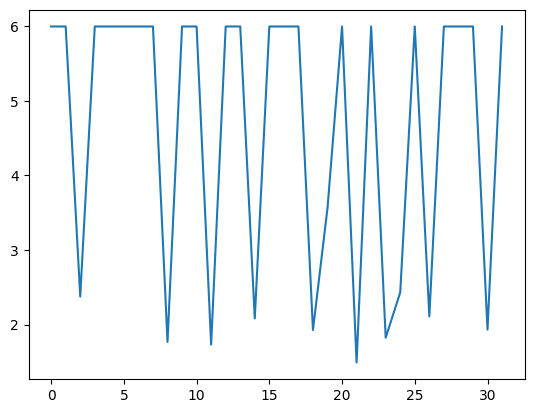

In [63]:
plt.plot(reward)
plt.show()

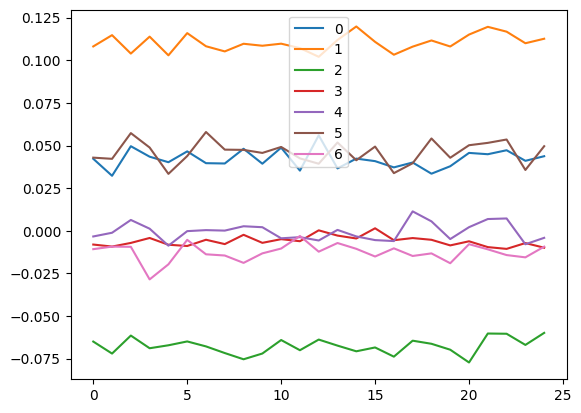

In [64]:
plt.plot(mean_action_arr[:,0], label='0')
plt.plot(mean_action_arr[:,1], label='1')
plt.plot(mean_action_arr[:,2], label='2')
plt.plot(mean_action_arr[:,3], label='3')
plt.plot(mean_action_arr[:,4], label='4')
plt.plot(mean_action_arr[:,5], label='5')
plt.plot(mean_action_arr[:,6], label='6')
plt.legend()
plt.show()